Le but de ce NB est de pouvoir observer le comportement de la classe `GaussianNonLinearCalibration` lorsque les matrices B et R deviennent extremes :
* si la matrice de covariance B est grande, on a peu de confiance dans l'a-priori et les observations dominent : à la limite, cela revient à faire des moindres carrés non linéaires,
* si la matrice de covariance R est grande, on a peu de confiance dans les observations et l'à-priori domine : à la limite, cela revient à conserver l'à-priori.

## Generate the observations

In [1]:
import numpy as np
import openturns as ot

We define the model $g$ which has 4 inputs and one output H.

The nonlinear least squares does not take into account for bounds in the parameters. Therefore, we ensure that the output is computed whatever the inputs. The model fails into two situations:

* if $K_s<0$,
* if $Z_v-Z_m<0$.

In these cases, we return an infinite number, so that the optimization algorithm does not get trapped.

In [2]:
def functionFlooding(X) :
    L = 5.0e3
    B = 300.0
    Q, K_s, Z_v, Z_m = X
    alpha = (Z_m - Z_v)/L
    if alpha < 0.0 or K_s <= 0.0:
        H = np.inf
    else:
        H = (Q/(K_s*B*np.sqrt(alpha)))**(3.0/5.0)
    return [H]

In [3]:
g = ot.PythonFunction(4, 1, functionFlooding) 
g = ot.MemoizeFunction(g)
g.setOutputDescription(["H (m)"])

Create the input distribution for $Q$.

In [4]:
Qparam = ot.GumbelAB(1013., 558.)
Q = ot.ParametrizedDistribution(Qparam)
Q = ot.TruncatedDistribution(Q,ot.TruncatedDistribution.LOWER)
Q.setDescription(["Q (m3/s)"])
Q

class=TruncatedDistribution name=TruncatedDistribution distribution=class=ParametrizedDistribution parameters=class=GumbelAB name=Unnamed a=1013 b=558 distribution=class=Gumbel name=Gumbel dimension=1 alpha=0.00179211 beta=1013 bounds=class=Interval name=Unnamed dimension=1 lower bound=class=Point name=Unnamed dimension=1 values=[0] upper bound=class=Point name=Unnamed dimension=1 values=[19000.8] finite lower bound=[1] finite upper bound=[0] thresholdRealization=0.5

Set the parameters to be calibrated.

In [5]:
K_s = ot.Dirac(30.0)
Z_v = ot.Dirac(50.0)
Z_m = ot.Dirac(55.0)
K_s.setDescription(["Ks (m^(1/3)/s)"])
Z_v.setDescription(["Zv (m)"])
Z_m.setDescription(["Zm (m)"])

Create the joint input distribution.

In [6]:
inputRandomVector = ot.ComposedDistribution([Q, K_s, Z_v, Z_m])

Create a Monte-Carlo sample of the output H.

In [7]:
nbobs = 100
inputSample = inputRandomVector.getSample(nbobs)
outputH = g(inputSample)

Observe the distribution of the output H.

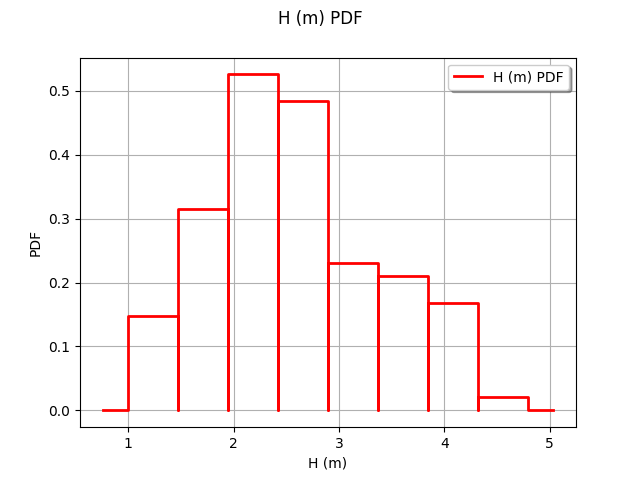

In [8]:
ot.HistogramFactory().build(outputH).drawPDF()

Generate the observation noise and add it to the output of the model.

In [9]:
sigmaObservationNoiseH = 0.1 # (m)
noiseH = ot.Normal(0.,sigmaObservationNoiseH)
sampleNoiseH = noiseH.getSample(nbobs)
Hobs = outputH + sampleNoiseH

Plot the Y observations versus the X observations.

In [10]:
Qobs = inputSample[:,0]

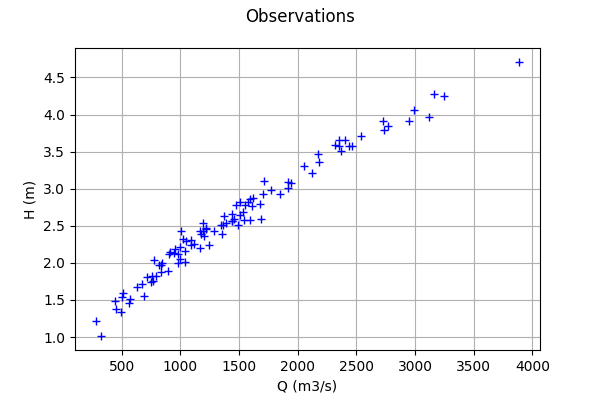

In [11]:
graph = ot.Graph("Observations","Q (m3/s)","H (m)",True)
cloud = ot.Cloud(Qobs,Hobs)
graph.add(cloud)
graph

## A visualisation class

In [12]:
"""
A graphics class to analyze the results of calibration.
"""

import pylab as pl
import openturns as ot
import openturns.viewer as otv

class CalibrationAnalysis:
    def __init__(self,calibrationResult,model,inputObservations,outputObservations):
        """
        Plots the prior and posterior distribution of the calibrated parameter theta.
    
        Parameters
        ----------
        calibrationResult : :class:`~openturns.calibrationResult`
            The result of a calibration.
    
        model : 2-d sequence of float
            The function to calibrate.
    
        inputObservations : :class:`~openturns.Sample`
            The sample of input values of the model linked to the observations.
    
        outputObservations : 2-d sequence of float
            The sample of output values of the model linked to the observations.
        """
        self.model = model
        self.outputAtPrior = None
        self.outputAtPosterior = None
        self.calibrationResult = calibrationResult
        self.observationColor = "blue"
        self.priorColor = "red"
        self.posteriorColor = "green"
        self.inputObservations = inputObservations
        self.outputObservations = outputObservations
        self.unitlength = 6 # inch
        # Compute yAtPrior
        meanPrior = calibrationResult.getParameterPrior().getMean()
        model.setParameter(meanPrior)
        self.outputAtPrior=model(inputObservations)
        # Compute yAtPosterior
        meanPosterior = calibrationResult.getParameterPosterior().getMean()
        model.setParameter(meanPosterior)
        self.outputAtPosterior=model(inputObservations)
        return None

    def drawParameterDistributions(self):
        """
        Plots the prior and posterior distribution of the calibrated parameter theta.
        """
        thetaPrior = self.calibrationResult.getParameterPrior()
        thetaDescription = thetaPrior.getDescription()
        thetaPosterior = self.calibrationResult.getParameterPosterior()
        thetaDim = thetaPosterior.getDimension()
        fig = pl.figure(figsize=(16, 4))
        for i in range(thetaDim):
            graph = ot.Graph("",thetaDescription[i],"PDF",True,"topright")
            # Prior distribution
            thetaPrior_i = thetaPrior.getMarginal(i)
            priorPDF = thetaPrior_i.drawPDF()
            priorPDF.setColors([self.priorColor])
            priorPDF.setLegends(["Prior"])
            graph.add(priorPDF)
            # Posterior distribution
            thetaPosterior_i = thetaPosterior.getMarginal(i)
            postPDF = thetaPosterior_i.drawPDF()
            postPDF.setColors([self.posteriorColor])
            postPDF.setLegends(["Posterior"])
            graph.add(postPDF)
            '''
            If the prior is a Dirac, set the vertical axis bounds to the posterior. 
            Otherwise, the Dirac set to [0,1], where the 1 can be much larger 
            than the maximum PDF of the posterior.
            '''
            if (thetaPrior_i.getName()=="Dirac"):
                # The vertical (PDF) bounds of the posterior
                postbb = postPDF.getBoundingBox()
                pdf_upper = postbb.getUpperBound()[1]
                pdf_lower = postbb.getLowerBound()[1]
                # Set these bounds to the graph
                bb = graph.getBoundingBox()
                graph_upper = bb.getUpperBound()
                graph_upper[1] = pdf_upper
                bb.setUpperBound(graph_upper)
                graph_lower = bb.getLowerBound()
                graph_lower[1] = pdf_lower
                bb.setLowerBound(graph_lower)
                graph.setBoundingBox(bb)
            # Add it to the graphics
            ax = fig.add_subplot(1, thetaDim, i+1)
            _ = otv.View(graph, figure=fig, axes=[ax])
        return fig
    
    def drawObservationsVsPredictions(self):
        """
        Plots the output of the model depending 
        on the output observations before and after calibration.
        """
        
        ySize = self.outputObservations.getSize()
        yDim = self.outputObservations.getDimension()
        graph = ot.Graph("","Observations","Predictions",True,"topleft")
        # Plot the diagonal
        if (yDim==1):
            graph = self._drawObservationsVsPredictions1Dimension(self.outputObservations,self.outputAtPrior,self.outputAtPosterior)
        elif (ySize==1):
            outputObservations = ot.Sample(self.outputObservations[0],1)
            outputAtPrior = ot.Sample(self.outputAtPrior[0],1)
            outputAtPosterior = ot.Sample(self.outputAtPosterior[0],1)
            graph = self._drawObservationsVsPredictions1Dimension(outputObservations,outputAtPrior,outputAtPosterior)
        else:
            fig = pl.figure(figsize=(self.unitlength*yDim, self.unitlength))
            for i in range(yDim):
                outputObservations = self.outputObservations[:,i]
                outputAtPrior = self.outputAtPrior[:,i]
                outputAtPosterior = self.outputAtPosterior[:,i]
                graph = self._drawObservationsVsPredictions1Dimension(outputObservations,outputAtPrior,outputAtPosterior)
                ax = fig.add_subplot(1, yDim, i+1)
                _ = otv.View(graph, figure=fig, axes=[ax])

        return graph

    def _drawObservationsVsPredictions1Dimension(self,outputObservations,outputAtPrior,outputAtPosterior):
        """
        Plots the output of the model depending 
        on the output observations before and after calibration.
        Can manage only 1D samples.
        """
        yDim = outputObservations.getDimension()
        ydescription = outputObservations.getDescription()
        xlabel = "%s Observations" % (ydescription[0])
        ylabel = "%s Predictions" % (ydescription[0])
        graph = ot.Graph("",xlabel,ylabel,True,"topleft")
        # Plot the diagonal
        if (yDim==1):
            curve = ot.Curve(outputObservations, outputObservations)
            curve.setColor(self.observationColor)
            graph.add(curve)
        else:
            raise TypeError('Output observations are not 1D.')
        # Plot the predictions before
        yPriorDim = outputAtPrior.getDimension()
        if (yPriorDim==1):
            cloud = ot.Cloud(outputObservations, outputAtPrior)
            cloud.setColor(self.priorColor)
            cloud.setLegend("Prior")
            graph.add(cloud)
        else:
            raise TypeError('Output prior predictions are not 1D.')
        # Plot the predictions after
        yPosteriorDim = outputAtPosterior.getDimension()
        if (yPosteriorDim==1):
            cloud = ot.Cloud(outputObservations, outputAtPosterior)
            cloud.setColor(self.posteriorColor)
            cloud.setLegend("Posterior")
            graph.add(cloud)
        else:
            raise TypeError('Output posterior predictions are not 1D.')
        return graph
    
    def drawResiduals(self):
        """
        Plot the distribution of the residuals and 
        the distribution of the observation errors. 
        """    
        ySize = self.outputObservations.getSize()
        yDim = self.outputObservations.getDimension()
        yPriorSize = self.outputAtPrior.getSize()
        yPriorDim = self.outputAtPrior.getDimension()
        if (yDim==1):
            observationsError = self.calibrationResult.getObservationsError()
            graph = self._drawResiduals1Dimension(self.outputObservations,self.outputAtPrior,self.outputAtPosterior,observationsError)
        elif (ySize==1):
            outputObservations = ot.Sample(self.outputObservations[0],1)
            outputAtPrior = ot.Sample(self.outputAtPrior[0],1)
            outputAtPosterior = ot.Sample(self.outputAtPosterior[0],1)
            observationsError = self.calibrationResult.getObservationsError()
            # In this case, we cannot draw observationsError ; just 
            # pass the required input argument, but it is not actually used.
            graph = self._drawResiduals1Dimension(outputObservations,outputAtPrior,outputAtPosterior,observationsError)
        else:
            observationsError = self.calibrationResult.getObservationsError()
            fig = pl.figure(figsize=(self.unitlength*yDim, self.unitlength))
            for i in range(yDim):
                outputObservations = self.outputObservations[:,i]
                outputAtPrior = self.outputAtPrior[:,i]
                outputAtPosterior = self.outputAtPosterior[:,i]
                observationsErrorYi = observationsError.getMarginal(i)
                graph = self._drawResiduals1Dimension(outputObservations,outputAtPrior,outputAtPosterior,observationsErrorYi)
                ax = fig.add_subplot(1, yDim, i+1)
                _ = otv.View(graph, figure=fig, axes=[ax])
        return graph

    def _drawResiduals1Dimension(self,outputObservations,outputAtPrior,outputAtPosterior,observationsError):
        """
        Plot the distribution of the residuals and 
        the distribution of the observation errors. 
        Can manage only 1D samples.
        """    
        ydescription = outputObservations.getDescription()
        xlabel = "%s Residuals" % (ydescription[0])
        graph = ot.Graph("Residuals analysis",xlabel,"Probability distribution function",True,"topright")
        yDim = outputObservations.getDimension()
        yPriorDim = outputAtPrior.getDimension()
        yPosteriorDim = outputAtPrior.getDimension()
        if (yDim==1) and (yPriorDim==1) :
            posteriorResiduals = outputObservations - outputAtPrior
            kernel = ot.KernelSmoothing()
            fittedDist = kernel.build(posteriorResiduals)
            residualPDF = fittedDist.drawPDF()
            residualPDF.setColors([self.priorColor])
            residualPDF.setLegends(["Prior"])
            graph.add(residualPDF)
        else:
            raise TypeError('Output prior observations are not 1D.')
        if (yDim==1) and (yPosteriorDim==1) :
            posteriorResiduals = outputObservations - outputAtPosterior
            kernel = ot.KernelSmoothing()
            fittedDist = kernel.build(posteriorResiduals)
            residualPDF = fittedDist.drawPDF()
            residualPDF.setColors([self.posteriorColor])
            residualPDF.setLegends(["Posterior"])
            graph.add(residualPDF)
        else:
            raise TypeError('Output posterior observations are not 1D.')
        # Plot the distribution of the observation errors
        if (observationsError.getDimension()==1):
            # In the other case, we just do not plot
            obserrgraph = observationsError.drawPDF()
            obserrgraph.setColors([self.observationColor])
            obserrgraph.setLegends(["Observation errors"])
            graph.add(obserrgraph)
        return graph

    def drawObservationsVsInputs(self):
        """
        Plots the observed output of the model depending 
        on the observed input before and after calibration.
        """
        xSize = self.inputObservations.getSize()
        ySize = self.outputObservations.getSize()
        xDim = self.inputObservations.getDimension()
        yDim = self.outputObservations.getDimension()
        xdescription = self.inputObservations.getDescription()
        ydescription = self.outputObservations.getDescription()
        # Observations
        if (xDim==1) and (yDim==1):
            graph = self._drawObservationsVsInputs1Dimension(self.inputObservations,self.outputObservations,self.outputAtPrior,self.outputAtPosterior)
        elif (xSize==1) and (ySize==1):
            inputObservations = ot.Sample(self.inputObservations[0],1)
            outputObservations = ot.Sample(self.outputObservations[0],1)
            outputAtPrior = ot.Sample(self.outputAtPrior[0],1)
            outputAtPosterior = ot.Sample(self.outputAtPosterior[0],1)
            graph = self._drawObservationsVsInputs1Dimension(inputObservations,outputObservations,outputAtPrior,outputAtPosterior)
        else:
            fig = pl.figure(figsize=(xDim*self.unitlength, yDim*self.unitlength))
            for i in range(xDim):
                for j in range(yDim):
                    k = xDim * j + i
                    inputObservations = self.inputObservations[:,i]
                    outputObservations = self.outputObservations[:,j]
                    outputAtPrior = self.outputAtPrior[:,j]
                    outputAtPosterior = self.outputAtPosterior[:,j]
                    graph = self._drawObservationsVsInputs1Dimension(inputObservations,outputObservations,outputAtPrior,outputAtPosterior)
                    ax = fig.add_subplot(yDim, xDim, k+1)
                    _ = otv.View(graph, figure=fig, axes=[ax])
        return graph

    def _drawObservationsVsInputs1Dimension(self,inputObservations,outputObservations,outputAtPrior,outputAtPosterior):
        """
        Plots the observed output of the model depending 
        on the observed input before and after calibration.
        Can manage only 1D samples.
        """
        xDim = inputObservations.getDimension()
        if (xDim!=1):
            raise TypeError('Input observations are not 1D.')
        yDim = outputObservations.getDimension()
        xdescription = inputObservations.getDescription()
        ydescription = outputObservations.getDescription()
        graph = ot.Graph("",xdescription[0],ydescription[0],True,"topright")
        # Observations
        if (yDim==1):
            cloud = ot.Cloud(inputObservations,outputObservations)
            cloud.setColor(self.observationColor)
            cloud.setLegend("Observations")
            graph.add(cloud)
        else:
            raise TypeError('Output observations are not 1D.')
        # Model outputs before calibration
        yPriorDim = outputAtPrior.getDimension()
        if (yPriorDim==1):
            cloud = ot.Cloud(inputObservations,outputAtPrior)
            cloud.setColor(self.priorColor)
            cloud.setLegend("Prior")
            graph.add(cloud)
        else:
            raise TypeError('Output prior predictions are not 1D.')
        # Model outputs after calibration
        yPosteriorDim = outputAtPosterior.getDimension()
        if (yPosteriorDim==1):
            cloud = ot.Cloud(inputObservations,outputAtPosterior)
            cloud.setColor(self.posteriorColor)
            cloud.setLegend("Posterior")
            graph.add(cloud)
        else:
            raise TypeError('Output posterior predictions are not 1D.')
        return graph

## Setting the calibration parameters

Define the value of the reference values of the $\theta$ parameter. In the bayesian framework, this is called the mean of the *prior* gaussian distribution. In the data assimilation framework, this is called the *background*.

In [13]:
KsInitial = 20.
ZvInitial = 49.
ZmInitial = 51.
thetaPrior = ot.Point([KsInitial,ZvInitial,ZmInitial])

The following statement create the calibrated function from the model. The calibrated parameters Ks, Zv, Zm are at indices 1, 2, 3 in the inputs arguments of the model.

In [14]:
calibratedIndices = [1,2,3]
mycf = ot.ParametricFunction(g, calibratedIndices, thetaPrior)

## Gaussian non linear calibration

The standard deviation of the observations.

In [15]:
sigmaH = 0.5 # (m^2)

Define the covariance matrix of the output Y of the model.

In [16]:
errorCovariance = ot.CovarianceMatrix(1)
errorCovariance[0,0] = sigmaH**2

Defined the covariance matrix of the parameters $\theta$ to calibrate.

In [17]:
def FloodingGaussianNonLinearCalibration(sigmaKs, sigmaZv, sigmaZm):
    sigma = ot.CovarianceMatrix(3)
    sigma[0,0] = sigmaKs**2
    sigma[1,1] = sigmaZv**2
    sigma[2,2] = sigmaZm**2
    #
    # BLUE approximation for the covariance
    ot.ResourceMap_SetAsUnsignedInteger("GaussianNonLinearCalibration-BootstrapSize",0)
    #
    algo = ot.GaussianNonLinearCalibration(mycf, Qobs, Hobs, thetaPrior, sigma, errorCovariance)
    algo.run()
    calibrationResult = algo.getResult()
    thetaStar = calibrationResult.getParameterMAP()
    print("ThetaStar = ", thetaStar)
    mypcr = CalibrationAnalysis(calibrationResult,mycf, Qobs,Hobs)
    _ = mypcr.drawParameterDistributions()
    return None

ThetaStar =  [20.0025,48.9877,51.0123]


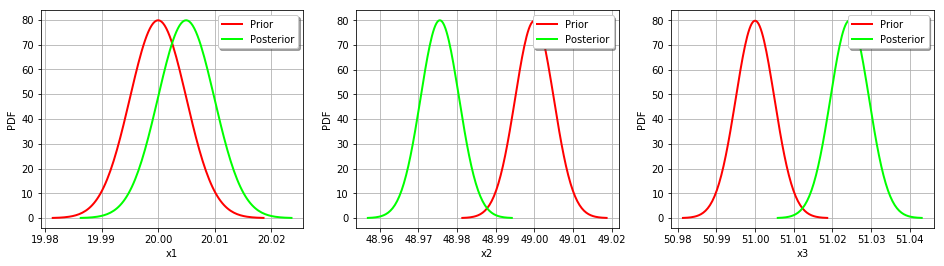

In [18]:
# Small background uncertainties : only the background matters
sigmaKs = 0.005; sigmaZv = 0.005; sigmaZm = 0.005
FloodingGaussianNonLinearCalibration(sigmaKs, sigmaZv, sigmaZm)

Le paramètre $\theta^\star$ est très proche de l'a-priori. Par exemple, $K_s^\star=20.00$ est très proche de l'a-priori $K_s = 20$. De meme, $Z_v^\star=48.99$ est très proche de l'a-priori $Z_v = 49$. Les deux distributions à priori et à posteriori sont très proches. 

ThetaStar =  [24.4611,46.8391,53.1609]


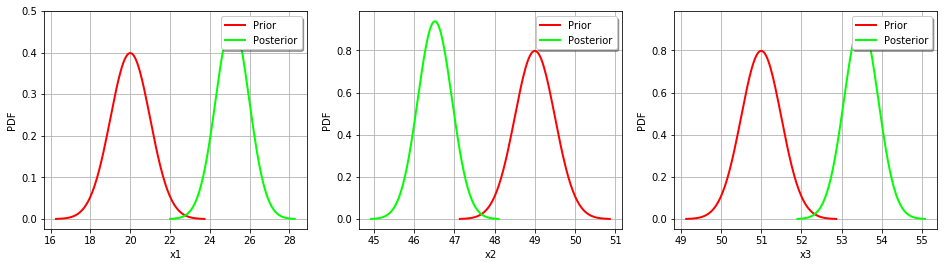

In [19]:
# Medium background uncertainties
sigmaKs = 1.; sigmaZv = 0.5; sigmaZm = 0.5
FloodingGaussianNonLinearCalibration(sigmaKs, sigmaZv, sigmaZm)

Le paramètre $\theta^\star$ est assez éloigné de l'a-priori. Par exemple, $K_s^\star=24.46$ est à mi-chemin entre l'a-priori $K_s = 20$ et la valeur "vraie" $K_s = 30$.  Les deux distributions à priori et à posteriori sont différentes. 

ThetaStar =  [30.8681,47.5951,52.4049]


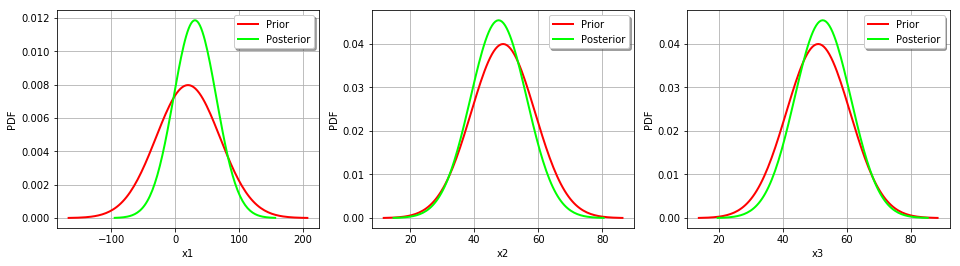

In [20]:
# Large background uncertainties : only the observations matters
sigmaKs = 50.; sigmaZv = 10.; sigmaZm = 10.
FloodingGaussianNonLinearCalibration(sigmaKs, sigmaZv, sigmaZm)

Les distributions sont très dispersées : on devrait plutot faire des moindres carrés dans cette situation.